# Example sheet 2: inference
Question sheet [[pdf]](http://www.cl.cam.ac.uk/teaching/1718/DataSci/ex2.pdf)

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats
import urllib
%matplotlib inline

## 0. Data import

This code fetches the dataset, imports it into Python, keeps only the rows with `police_force=='cambridgeshire'`,
and processes it to give the following vectors.

* `y` is a boolean vector, where `y[i]=True` means that the outcome for row `i` was $\textsf{find}$ and `y[i]=False` means the outcome was $\textsf{nothing}$.
* `e` is an integer vector, so that the ethnicity for row `i` is `ETHNICITY_LEVELS[e[i]]`, where `ETHNICITY_LEVELS = ['Asian', 'Black', 'White', 'Mixed', 'Other']`

In [2]:
# On Azure Notebooks, you are allocated a new virtual machine for every session,
# and the machine is de-allocated after every session and all its storage is destroyed,
# so you need to re-download the file each time. On a local machine, you don't need to
# run this each time.

!wget "https://teachingfiles.blob.core.windows.net/founds/stop-and-search.csv"

--2017-11-16 14:59:11--  https://teachingfiles.blob.core.windows.net/founds/stop-and-search.csv
Resolving webproxy (webproxy)... 10.116.64.36
Connecting to webproxy (webproxy)|10.116.64.36|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 179821411 (171M) [text/csv]
Saving to: 'stop-and-search.csv.3'

stop-and-search.csv 100%[===================>] 171.49M  11.0MB/s    in 17s     

2017-11-16 14:59:30 (9.90 MB/s) - 'stop-and-search.csv.3' saved [179821411/179821411]



In [3]:
df = pandas.read_csv('stop-and-search.csv')
# Some entries have ethnicity equal to np.nan, meaning the value is missing in the dataset.
# Exclude these records. Let ok be a vector indicating whether ethnicity is present
# and the police_force is 'cambridgeshire'
ok = np.array([e is not np.nan for e in df['Officer-defined ethnicity']])
ok = np.logical_and(ok, df['police_force'] == 'cambridgeshire')
y = df['Outcome'][ok].values != 'Nothing found - no further action'

# It will be faster to work purely with numbers rather than string lookup.
# Prepare an integer vector e, a numerically-coded version of ethnicity, restricted to ok records. 
ETHNICITY_LEVELS = ['Asian', 'Black', 'White', 'Mixed', 'Other']
ethnicity_code = {k:i for i,k in enumerate(ETHNICITY_LEVELS)}
e = np.array([ethnicity_code[v] for v in df['Officer-defined ethnicity'][ok]])

## Question 1. Bayesian confidence intervals


(a) Let $\theta$ consist of 5 independent random variables drawn from the $\operatorname{Beta}(\delta,\delta)$ distribution, where
$\delta = 0.5$. Calculate the posterior distribution of $\theta$. Implement a function `posterior_sample(size)` that generates size independent samples of $\theta$ drawn from the posterior distribution. Each sample should be a vector of length 5.


Prior Belief: $\theta \sim \operatorname{Beta}(\delta, \delta)$ where $\delta = 1/2$.

Bayes Rule:
$$
\mathbb{Pr}(\Theta = \theta \mid \text{data}) = \frac{\mathbb{P}(\text{data} \mid \Theta = \theta) \mathbb{Pr}(\Theta = \theta)}{\mathbb{P}(\text{data})}
$$
where $\mathbb{P}(\text{data})$ is constant. Let it be $D$.

By law of independence:
$$
\begin{align}
\mathbb{Pr}(\Theta = \theta) &= \mathbb{Pr}(\Theta_\text{Asian} = \theta_\text{Asian}, \Theta_\text{Black} = \theta_\text{Black}, ...) \\
&= \mathbb{Pr}(\Theta_\text{Asian} = \theta_\text{Asian}) \mathbb{Pr}(\Theta_\text{Black} = \theta_\text{Black}) ... \\
\end{align}
$$

Since PDF of $\operatorname{Beta}(\alpha, \beta)$ is:
$$ 
f_X(x) = \frac{x^{\alpha - 1} (1 - x)^{\beta - 1}}{B(\alpha, \beta)}
$$

where $B$ is the beta function, which is constant. Since $\theta \sim \operatorname{Beta}(\delta, \delta)$ where $\delta = 1/2$:
$$
\mathbb{Pr}(\Theta = \theta) = \frac{1}{C} \prod_{\theta_e \in \theta} \theta_e^{\delta-1} (1-\theta_e)^{\delta-1}
$$
where $C$ is $B^{|\theta|}$ and $e$ is ethinicity.


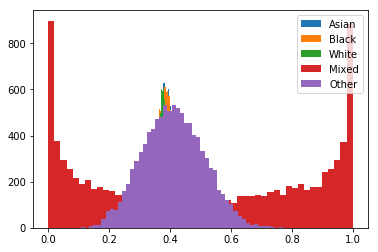

(10000, 5)


In [4]:
# dist = b
n = np.count_nonzero(e==0)
k = np.count_nonzero(y[e==0])
delta = 0.5

def single_posterior_sample():
    for i in ethnicity_code.values():
        n = np.count_nonzero(e==i) # n_e 
        k = np.count_nonzero(y[e==i]) # n_e,find 
        yield np.random.beta(a=delta+k, b=delta+n-k)

def posterior_sample(size):
    return np.array([list(single_posterior_sample()) for i in range(size)])
        
theta = posterior_sample(10000)
for l, i in ethnicity_code.items():
    plt.hist([s[i] for s in theta], bins=50, label=l)
plt.legend()
plt.show()

print(theta.shape)

(b) Given a sample of $\theta$, define the maximum discrepancy to be
$$
d(\theta) = max_{e, e'} |\theta_e - \theta_{e'}|
$$
Plot a histogram of the posterior distribution of $d(\theta)$.

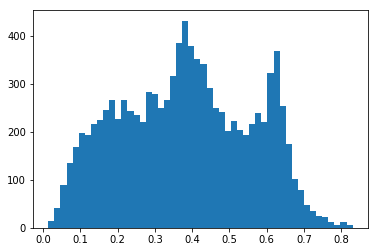

In [5]:
def d(theta):
    rows,cols = theta.shape
    res = np.zeros(rows)
    for i in range(cols):
        for j in range(cols):
            res = np.maximum(res, np.abs(theta[:,i] - theta[:,j]))
    return res

plt.hist(d(theta), bins=50)
plt.show()

(c) You should have found that the posterior distribution of $d(\theta)$ is highly variable, because the
dataset has few cases of $e_i = \text{Mixed}$ and none of $e_i = \text{Other}$. Plot the histogram again, but
showing only the maximum discrepancy of $(\theta_\text{Asian}, \theta_\text{Black}, \theta_\text{White})$. We’ll call this $d_3(\theta)$.


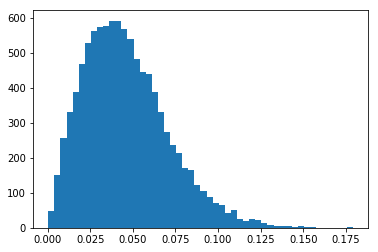

In [6]:
d_3 = d(theta[:,:3])
plt.hist(d_3, bins=50)
plt.show()

(d) Find a 95% confidence interval of the form:
$$
\mathbb{P}(d_3(\theta) < c) = 95\%
$$

In [7]:
#No Clue
sig_sq = np.var(d_3)
mu = np.mean(d_3)

scipy.stats.norm.interval(0.95, loc=mu, scale=sig_sq)

(0.044808918357489236, 0.047186946778570077)

## Question 2. Frequentist confidence interval

Let's illustrate the Python approach for a single ethnic group.

Following lecture notes &sect;3.2.2, let $n$ be the number of rows with
$e_i=\textsf{Asian}$, and
let $k$ be the number of rows with $e_i=\textsf{Asian}$ and $y_i=\textsf{find}$.
Model $k$ as drawn from a random variable $K\sim\operatorname{Bin}(n,\theta_{\textsf{Asian}})$.
The maximum likelihood estimator is just $\hat{\theta}_{\textsf{Asian}}=k/n$.

Some links:
* [formulae for the binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution)
* [generating binomial random variables](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.binomial.html)
* [distribution function etc.](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.binom.html)

In [8]:
# ETHNICITY_LEVELS[0]=='Asian', so I'm interested in e==0.
n = np.count_nonzero(e==0)
k = np.count_nonzero(y[e==0])

The bootstrap resampling method is a way to approximate probabilities. It says, for example,
$$
\mathbb{P}\bigl(\theta_{\textsf{Asian}} \in [\hat{\theta}_{\textsf{Asian}}(k)-e,\; \hat{\theta}_{\textsf{Asian}}(k)+e]\bigr)
\approx
\mathbb{P}\bigl(\hat{\theta}_{\textsf{Asian}}(k) \in [\hat{\theta}_{\textsf{Asian}}(K^*)-e,\; \hat{\theta}_{\textsf{Asian}}(K^*)+e]\bigr).
$$
Here $\hat{\theta}_{\textsf{Asian}}(k)$ means "the maximum likelihood estimator as computed from data $k$", and $K^*$ is a random variable, a resampled version of $K$.

In [9]:
# Draw 10000 samples of K*
samples = 10000
K_star = np.random.binomial(n, k/n, size=samples)

# Estimate the probability Prob(k/n in [K*/n-e, K*/n+e])
# I tweaked e until I got an answer that's roughly 0.95.
e = 0.0633
np.count_nonzero(np.logical_and(k/n >= K_star/n-e, k/n <= K_star/n+e)) / samples

0.9535

## Question 3. Frequentist hypothesis testing
_No code snippets provided_

## Question 4. Natural parameters

If you have produced a matrix with samples of $\theta$, one row per sample, one column per ethnic group, 
you could plot it with a plain scatterplot. Or you could generate a fancier plot, e.g. a heatmap or a contour plot.

In [10]:
# dummy data
theta = np.minimum(1,np.maximum(0,np.random.normal(loc=0.75, scale=0.1, size=(10000,5))))

/home/nbuser/anaconda3_431/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


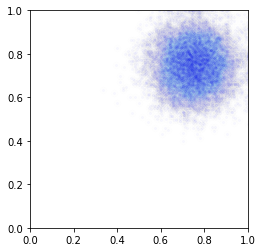

In [11]:
# Simple scatterplot
# Because I have lots of points, I use some visual tricks (double-plotting at different size/alpha)
# to try to convey the shape of the data a bit better.
plt.scatter(theta[:,0], theta[:,1], alpha=.003, s=50, color='lightblue') 
plt.scatter(theta[:,0], theta[:,1], alpha=.02, s=4, color='blue')
plt.axes().set_aspect('equal')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

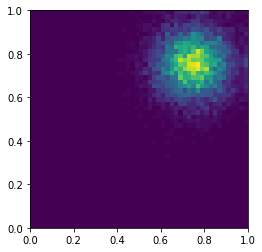

In [12]:
# Heatmap
counts,x,y = np.histogram2d(theta[:,0], theta[:,1], bins=[50,50], range=[[0,1],[0,1]])
plt.imshow(counts, extent=(x[0],x[-1],y[0],y[-1]), origin='lower');

## Question 5. Model selection

Here is a cunning matrix-oriented way to generate values of $Y$. Whatever you pass in as `x1` and `x2`, it generates a result with sensible dimension.

In [13]:
def Y(x1, x2, size=1):
    x1,x2 = np.array(x1), np.array(x2)
    wantshape = (size,) + (x1+x2).shape
    return np.squeeze(np.random.normal(loc=5 + 3*x1 + 0.1*x2, scale=1, size=wantshape))

# For single values of x1 and x2, Y is a single value
print(Y(2,3))

# For vectors x1 and/or x2, Y is a vector
print(Y([1,2],[2,3]))
print(Y(1, [2,3]))

# For m*n matrices x1 and x2, Y is a size*m*n matrix
print(Y([[1,2],[3,4]], [[4,5],[6,7]], size=10).shape)

11.080155178337733
[  6.75707286  11.21093558]
[ 8.33570921  7.06557134]
(10, 2, 2)


Data import.

In [14]:
URL = "https://teachingfiles.blob.core.windows.net/founds/model_selection_sample.csv"
df = pandas.read_csv(urllib.request.urlopen(URL))
x1,x2,y = (df['x1'].values, df['x2'].values, df['y'].values)

### (b) Prediction accuracy

You can simplify your code if you write it with matrix notation. (This is good practice for when you get into TensorFlow.)

In [15]:
# Generate a mesh of points. This gives two matrices x1new and x2new, each 10*10.
x1new, x2new = np.meshgrid(np.linspace(-1.5,1.5,10), np.linspace(-1.5,1.5,10))
print(x1new.shape)

# Compute the expected value (according to your model).
# If you type in a simple maths formula, it will be applied pointwise to every point on the grid.
expected = 0.3 * x1new + 0.5 * x2new
print(expected.shape)

# Generate 1000 values at every point on the grid.
# The way we defined Y, it will return a 1000*10*10 array.
actual = Y(x1new, x2new, size=1000)
print(actual.shape)

(10, 10)
(10, 10)
(1000, 10, 10)


In [16]:
# Compute the error for every 1000*10*10 generated datapoint.
# Then flatten them all out into a list of length 100,000.
err = (actual - expected[np.newaxis,:,:]).reshape(-1)
err.shape

(100000,)

### (c) Parameter uncertainty via resampling

To sample $n$ values with replacement from $\{0,1,\dots,n-1\}$,

In [17]:
n = 10
np.random.choice(n, size=n)

array([1, 7, 9, 3, 9, 3, 5, 3, 1, 7])